In [29]:
import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
from interpax import Interpolator2D
import xarray as xr

# Generate random input data
key = random.PRNGKey(0)
x_train = random.uniform(key, (1000, 1), minval=-5, maxval=5)
y_train = jnp.sin(x_train)

In [24]:
import equinox as eqx

class MLP(eqx.Module):
    layers: list

    def __init__(self, layer_sizes, key):
        keys = random.split(key, len(layer_sizes) - 1)
        self.layers = [eqx.nn.Linear(m, n, key=k)
                       for m, n, k in zip(layer_sizes[:-1], layer_sizes[1:], keys)]

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))
        return self.layers[-1](x)

# Define model
model = MLP([1, 64, 64, 1], key)
# model = eqx.nn.MLP(1, 1, 64, 2, activation=jax.nn.relu, key = jax.random.PRNGKey(42))

In [25]:
def loss_fn(model, x, y):
    preds = jax.vmap(model)(x)
    return jnp.mean((preds - y) ** 2)


In [26]:
import optax

# Optimizer
optimizer = optax.adam(0.01)
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

#@jax.jit
def update(model, opt_state, x, y):
    grads = eqx.filter(jax.grad(loss_fn)(model, x, y), eqx.is_inexact_array)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return model, opt_state

# Training loop
for epoch in range(1000):
    model, opt_state = update(model, opt_state, x_train, y_train)


In [15]:
# Generate test data
x_test = jnp.linspace(-5, 5, 100).reshape(-1, 1)
y_test = jnp.sin(x_test)

# Predictions
predictions = jax.vmap(model)(x_test)

# You can now plot or evaluate the predictions against y_test


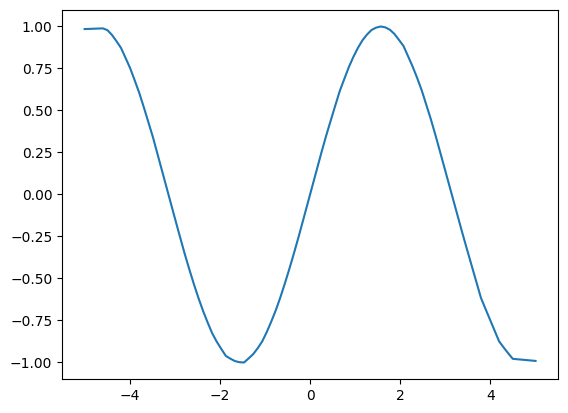

In [18]:
plt.plot(x_test, predictions)

In [30]:
flds = xr.open_dataset("data/all-fields.nc")

In [31]:
xax = flds.coords["x"].data
tax = flds.coords["t"].data

dx = xax[1]-xax[0]
xmax = xax[-1] + dx/2.
dt = tax[1]-tax[0]

In [56]:
key = random.PRNGKey(0)
t_train = random.uniform(key, (1000, 1), minval=0, maxval=1)
efield_interp = Interpolator2D(tax, xax, flds["force-(x)"].data, method="linear", period=(None, xmax))
efield_scaled = jax.vmap(lambda t: efield_interp(500 + 10*t, 3.4))
E_train = efield_scaled(t_train)

In [25]:
def loss_fn(model, t, E):
    preds = jax.vmap(model)(t)
    return jnp.mean((preds - E) ** 2)


In [65]:
model = MLP([1, 64, 64, 64, 1], key)
# Optimizer
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

@jax.jit
def update(model, opt_state, t, E):
    grads = eqx.filter(jax.grad(loss_fn)(model, t, E), eqx.is_inexact_array)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return model, opt_state

# Training loop
for epoch in range(1000):
    model, opt_state = update(model, opt_state, t_train, E_train)


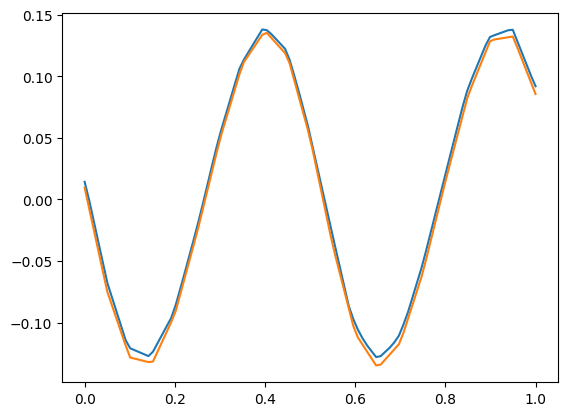

In [66]:
# Generate test data
t_test = jnp.linspace(0, 1, 100).reshape(-1, 1)
E_test = efield_scaled(t_test)

# Predictions
predictions = jax.vmap(model)(t_test)

# You can now plot or evaluate the predictions against y_test
plt.plot(t_test, predictions)
plt.plot(t_test, E_test)